# Multiclass Perceptron


Date: 07/09/2018

Version: 1.0

Environment: R and Jupyter notebook


## 1. Task Description

### Background. 
Assume we have N training examples {(x1,t1),...,(xN,tN)} where tn can get K discrete values {C1, ..., CK}, i.e. a K-class classification problem. We use 𝑦" to represent the predicted label of 𝑥"

### Model. 
To solve a K-class classification problem, we can learn K weight vectors wk, each of which corresponding to one of the classes.

### Prediction. 
In the prediction time, a data point x will be classified as argmaxk wk . x

## 2. Build the Model



In [1]:
library(ggplot2)

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”

#### Load data

In [2]:
### load data 

train.D <- read.csv('./assignment1_datasets/Task1D_train.csv')
test.D <- read.csv('./assignment1_datasets/Task1D_test.csv')
train.D.label <- train.D[,5]

#### Build a function to encode classes as numeric values 

In [3]:
### function to encode classes as numeric values 

label.into.dummy <- function(x) {
    switch(x,
           'C1' = eval(parse(text = train.D.label[1])),
           'C2' = eval(parse(text = train.D.label[50])),
           'C3' = eval(parse(text = train.D.label[70])))
    }


# change classes C1, C2, C3 to 1,2,3 for convenience
train.D[,5] <- apply(FUN = label.into.dummy, data.frame(train.D[,5]), MARGIN = 1)
test.D[,5] <- apply(FUN = label.into.dummy, data.frame(test.D[,5]), MARGIN = 1)

#### Data exploration

In [4]:
### data exploration 


# sizes
dim(train.D)
dim(test.D)

# values, there are three classes :C1, C2, C3
str(train.D)


[1] 75  5

[1] 75  5

'data.frame':	75 obs. of  5 variables:
 $ x1: num  5.1 4.7 5 4.6 4.4 5.4 4.8 5.8 5.4 5.7 ...
 $ x2: num  3.5 3.2 3.6 3.4 2.9 3.7 3 4 3.9 3.8 ...
 $ x3: num  1.4 1.3 1.4 1.4 1.4 1.5 1.4 1.2 1.3 1.7 ...
 $ x4: num  0.2 0.2 0.2 0.3 0.2 0.2 0.1 0.2 0.4 0.3 ...
 $ y : num  1 1 1 1 1 1 1 1 1 1 ...


#### Set training and testing data

In [5]:
# set training data, training label, testing data, and testing label 

train.D.label <- train.D[,5]
train.D.data <- train.D[,1:4]
train.D.len <- nrow(train.D.data)

test.D.data <- test.D[,1:4]
test.D.label <- test.D[,5]
test.D.len <- nrow(test.D.data)

#### Build a function to calculate test error (misclassification rate)

In [6]:
### function to calculate misclassification rate using current weight vector on test set 
### be used in the while loop below

prediction.error <- function(weight.vector, test.data, test.label){
    
    
    # empty dataframe to record actual labels and predicted labels
    miss.label <- data.frame('actual' = test.label, 'predict' = rep(NA))
    
    # basis function for intercept. add a column of 1 as x_0 
    basis <- as.matrix(cbind(1, test.data))
    
    # loop through data row by row 
    for (i in 1:nrow(test.data)){
        
        # empty vector to store the score of each class
        pred.vector <- c()
        
        # predict the class whose weight vector produces the highest score
        for (k in 1:n.class){
            
            # save the max score of each weight  
            pred.vector[k] <- weight.vector[k,] %*% basis[i,]
        }
        
        # choose the label with the highest score 
        miss.label[i,2] <- which.max(pred.vector)
    }
    
    # calculate misclassification rate
    sum(ifelse(miss.label[,1] == miss.label[,2], 0, 1)) / test.D.len

}

In [7]:
options(warn=-1)

## 3. Different Learning Rate 
### 3.1 Decrease learning rate by 0.01

In [8]:
set.seed(123)

### initialisation: set parameters

eta <- 0.09 # learning rate
epsilon <- 0.01 # stoping criterion: when only 1
n.max <- 100 # maximum number of iterations
n.class <- length(unique(train.D.label)) # number of classes 
n <- 1 # counter 
terminate <- FALSE # termination status


# empty weight vector of a set of 3 weight vectors
weight.vector <- matrix(c(runif(5), runif(5), runif(5)), nrow=3)

# empty dataframe to store the number of misclassification rate every 5 datapoints
error <- data.frame('n_mini_batch' = seq(1, (n.max * train.D.len/5)),
                    'n_misclassified' = rep(NA))

# number of mini-batch
er_row <- 1

# train the model
while(!terminate){
    
    terminate <- n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <= epsilon

    # shuffle data
    train.index <- sample(nrow(train.D))
    train.data <- train.D.data[train.index,]
    train.label <- train.D.label[train.index]
    
    
    # basis function for intercept. add a column of 1 as x_0 
    basis <- as.matrix(cbind(1, train.data))
    
    # loop through data by row
    for (i in 1:train.D.len){
        
        if (n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <=epsilon) {terminate<-TRUE;break}
        
        # empty vector to store the score of each class
        pred.vector <- c()
        
        # predict the class whose weight vector produces the highest score
        for (k in 1:n.class){
            
            # collect the max score of each weight  
            pred.vector[k] <- weight.vector[k,] %*% basis[i,]
        }
        
        
        
        # choose the label with the highest score 
        prediction <- which.max(pred.vector)

        # get the corresponding train label
        true.label <- train.label[i] 

        
        
        # wrongly labeled, update weights. otherwise skip this step
        if (true.label != prediction) {
            
            
            # decrease score of the wrong weight
            weight.vector[prediction,] <- weight.vector[prediction,] - (eta * basis[i,])
            
            # increase score of the actual weight
            weight.vector[true.label,] <- weight.vector[true.label,] + (eta * basis[i,])
            
            eta <- eta * 0.99
        }
        
        
        
        # evaluate the model every 5 datapoints  
        if (i %% 5 == 0) {
            # test the model on testing set to calculate the number of misclassified classes 
            error[er_row, 2] <- prediction.error(weight.vector, test.D.data, test.D.label)

            # row in error dataframe
            er_row <- er_row + 1

        }
        
    }
    
    # update iteration counter
    n <- n +1
    
    # repeat until maximum number of iteration is reached or the error is smaller than desired 
    terminate <- n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <= epsilon
    
}


error <- error[1:er_row,]

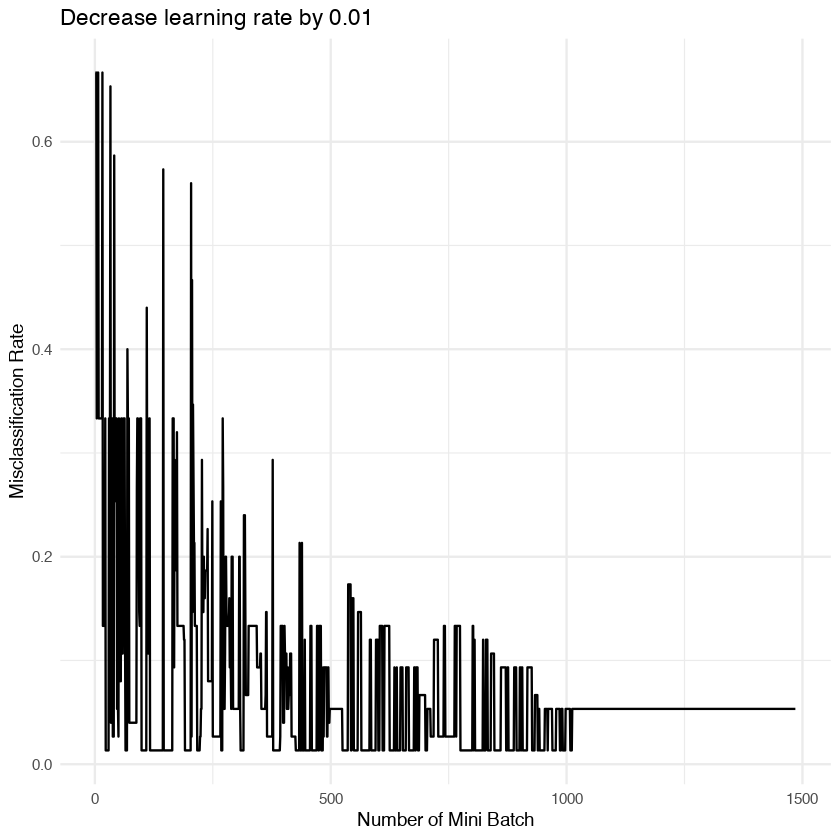

In [9]:
# plot the test error 

ggplot(error, aes(x = n_mini_batch, y = n_misclassified)) + 
    geom_line() + 
    theme_minimal() + 
    ggtitle('Decrease learning rate by 0.01') + 
    labs(x = 'Number of Mini Batch', y = 'Misclassification Rate')

### 3.2 Decrease learning rate by 0.001

In [10]:
set.seed(123)

### initialisation: set parameters

eta <- 0.09 # learning rate
epsilon <- 0.01 # stoping criterion: when only 1
n.max <- 100 # maximum number of iterations
n.class <- length(unique(train.D.label)) # number of classes 
n <- 1 # counter 
terminate <- FALSE # termination status


# empty weight vector of a set of 3 weight vectors
weight.vector <- matrix(c(runif(5), runif(5), runif(5)), nrow=3)

# empty dataframe to store the number of misclassification rate every 5 datapoints
error <- data.frame('n_mini_batch' = seq(1, (n.max * train.D.len/5)),
                    'n_misclassified' = rep(NA))

# number of mini-batch
er_row <- 1

# train the model
while(!terminate){
    
    terminate <- n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <= epsilon

    # shuffle data
    train.index <- sample(nrow(train.D))
    train.data <- train.D.data[train.index,]
    train.label <- train.D.label[train.index]
    
    
    # basis function for intercept. add a column of 1 as x_0 
    basis <- as.matrix(cbind(1, train.data))
    
    # loop through data by row
    for (i in 1:train.D.len){
        
        
        if (n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <=epsilon) {terminate<-TRUE;break}
        
        
        # empty vector to store the score of each class
        pred.vector <- c()
        
        # predict the class whose weight vector produces the highest score
        for (k in 1:n.class){
            
            # collect the max score of each weight  
            pred.vector[k] <- weight.vector[k,] %*% basis[i,]
        }
        
        
        
        # choose the label with the highest score 
        prediction <- which.max(pred.vector)

        # get the corresponding train label
        true.label <- train.label[i] 

        
        
        # wrongly labeled, update weights. otherwise skip this step
        if (true.label != prediction) {
            
            
            # decrease score of the wrong weight
            weight.vector[prediction,] <- weight.vector[prediction,] - (eta * basis[i,])
            
            # increase score of the actual weight
            weight.vector[true.label,] <- weight.vector[true.label,] + (eta * basis[i,])
            
            eta <- eta * 0.999
        }
        
        
        
        # evaluate the model every 5 datapoints  
        if (i %% 5 == 0) {
            # test the model on testing set to calculate the number of misclassified classes 
            error[er_row, 2] <- prediction.error(weight.vector, test.D.data, test.D.label)

            # row in error dataframe
            er_row <- er_row + 1

        }
        
    }
    
    # update iteration counter
    n <- n +1
    
    # repeat until maximum number of iteration is reached or the error is smaller than desired 
    terminate <- n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <= epsilon
    
}


error <- error[1:er_row,]

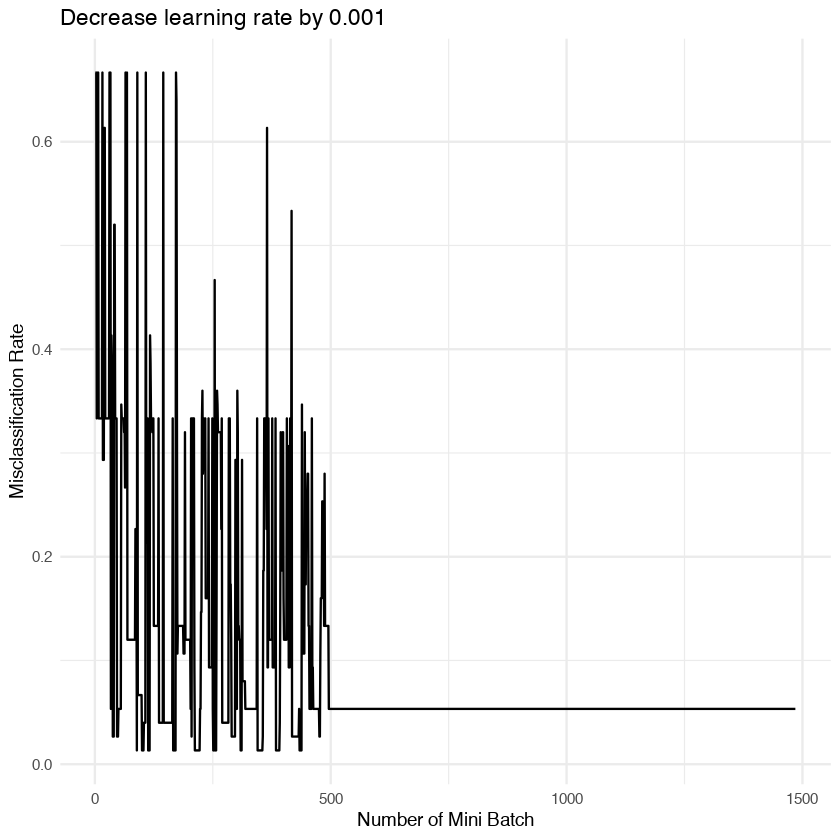

In [11]:
# plot the test error 
ggplot(error, aes(x = n_mini_batch, y = n_misclassified)) + 
    geom_line() + 
    theme_minimal() + 
    ggtitle('Decrease learning rate by 0.001') + 
    labs(x = 'Number of Mini Batch', y = 'Misclassification Rate')

  ### 3.3 Learning rate remains the same at 0.09

In [12]:
set.seed(123)

### initialisation: set parameters

eta <- 0.09 # learning rate
epsilon <- 0.01 # stoping criterion: when only 1
n.max <- 100 # maximum number of iterations
n.class <- length(unique(train.D.label)) # number of classes 
n <- 1 # counter 
terminate <- FALSE # termination status


# empty weight vector of a set of 3 weight vectors
weight.vector <- matrix(c(runif(5), runif(5), runif(5)), nrow=3)

# empty dataframe to store the number of misclassification rate every 5 datapoints
error <- data.frame('n_mini_batch' = seq(1, (n.max * train.D.len/5)),
                    'n_misclassified' = rep(NA))

# number of mini-batch
er_row <- 1


# train the model
while(!terminate){
    
    terminate <- n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <= epsilon

    # shuffle data
    train.index <- sample(nrow(train.D))
    train.data <- train.D.data[train.index,]
    train.label <- train.D.label[train.index]
    
    
    # basis function for intercept. add a column of 1 as x_0 
    basis <- as.matrix(cbind(1, train.data))
    
    # loop through data by row
    for (i in 1:train.D.len){
        
        
        if (n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <=epsilon) {terminate<-TRUE;break}
        
        
        # empty vector to store the score of each class
        pred.vector <- c()
        
        # predict the class whose weight vector produces the highest score
        for (k in 1:n.class){
            
            # collect the max score of each weight  
            pred.vector[k] <- weight.vector[k,] %*% basis[i,]
        }
        
        
        
        # choose the label with the highest score 
        prediction <- which.max(pred.vector)

        # get the corresponding train label
        true.label <- train.label[i] 

        
        
        # wrongly labeled, update weights. otherwise skip this step
        if (true.label != prediction) {
            
            
            # decrease score of the wrong weight
            weight.vector[prediction,] <- weight.vector[prediction,] - (eta * basis[i,])
            
            # increase score of the actual weight
            weight.vector[true.label,] <- weight.vector[true.label,] + (eta * basis[i,])

        }
        
        
        
        # evaluate the model every 5 datapoints  
        if (i %% 5 == 0) {
            # test the model on testing set to calculate the number of misclassified classes 
            error[er_row, 2] <- prediction.error(weight.vector, test.D.data, test.D.label)

            # row in error dataframe
            er_row <- er_row + 1

        }
        
    }
    
    # update iteration counter
    n <- n +1
    
    # repeat until maximum number of iteration is reached or the error is smaller than desired 
    terminate <- n >= n.max | prediction.error(weight.vector, test.D.data, test.D.label) <= epsilon
    
}


error <- error[1:er_row,]

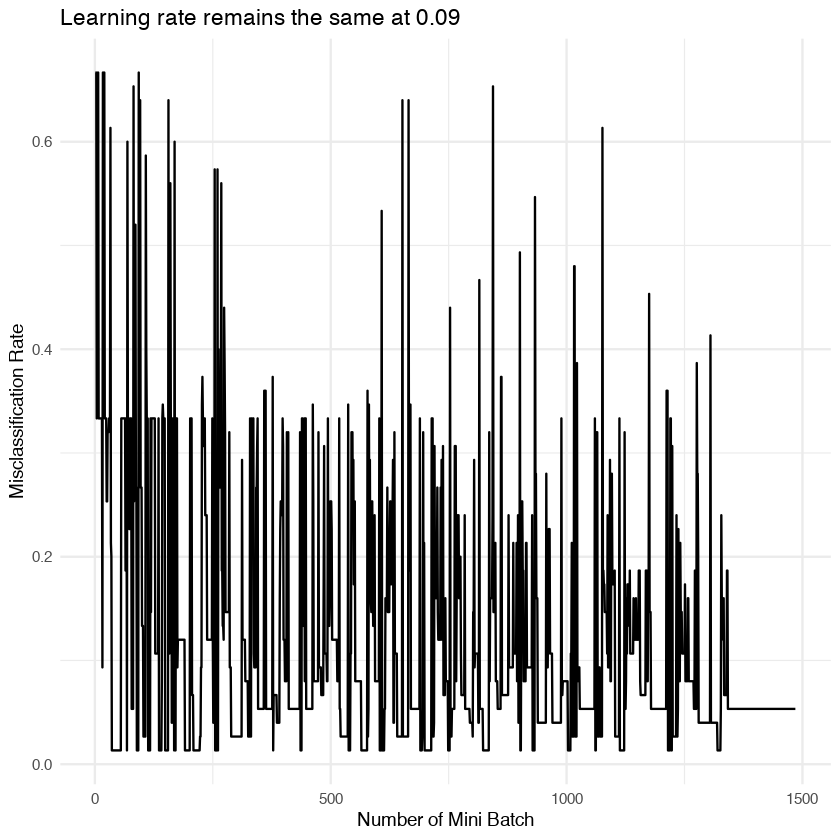

In [13]:
# plot test error 
ggplot(error, aes(x = n_mini_batch, y = n_misclassified)) + 
    geom_line() + 
    theme_minimal() + 
    ggtitle('Learning rate remains the same at 0.09') + 
    labs(x = 'Number of Mini Batch', y = 'Misclassification Rate')

## Discussion

Learning rate affects the convergence rate. Larger learning rate results in greater fluctuations in misclassification rate and faster convergence. All three plots show that the perceptron converges yet having different learning rates at different iterations of the main learning loop can help perceptron converge quicker.

